
# PeakPulse — Analytics & Dashboard (Concise Scaffold)

This notebook implements PeakPulse business definitions for **Active Users**, **Retention (D1/D7/D30/D90)**, **Conversion**, and exports assets.
Place CSVs in a `data/` folder next to this notebook.


In [1]:

# Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import timedelta
import warnings
warnings.filterwarnings("ignore")

DATA_DIR = Path("dataset folder path")
ACTIVE_SESSION_SECONDS = 30
INACTIVITY_CHURN_DAYS = 30
RETENTION_DAYS = [1,7,30,90]
plt.rcParams.update({"figure.figsize":(9,5),"axes.grid":True})
print("Ready.")


Ready.


In [2]:

# Load (flexible names aligned to provided schema)
def load_csv(p):
    try:
        return pd.read_csv(p, low_memory=False)
    except:
        return pd.DataFrame()

files = {
    "users": DATA_DIR/"users.csv",
    "subscriptions": DATA_DIR/"subscriptions.csv",
    "daily_scores": DATA_DIR/"daily_scores.csv",
    "app_sessions": DATA_DIR/"app_sessions.csv",
    "app_events": DATA_DIR/"app_events.csv",
    "activity_data": DATA_DIR/"activity_data.csv"
}
raw = {k: load_csv(v) for k,v in files.items()}
for k, df in raw.items():
    print(k, df.shape)

to_dt = lambda s: pd.to_datetime(s, errors="coerce")

# Standardize
u = raw["users"].rename(columns={"id":"user_id","signup_ts":"created_at"}).copy()
if "created_at" in u: u["created_at"] = to_dt(u["created_at"])

s = raw["subscriptions"].rename(columns={
    "subscription_start_date":"subscription_start_date",
    "subscription_end_date":"subscription_end_date",
    "is_canceled":"is_canceled"
}).copy()
for c in ["subscription_start_date","subscription_end_date","cancellation_date"]:
    if c in s: s[c] = to_dt(s[c])

ds = raw["daily_scores"].rename(columns={"date":"date"}).copy()
if "date" in ds: ds["date"] = to_dt(ds["date"]).dt.normalize()

asess = raw["app_sessions"].rename(columns={
    "session_start":"session_start","session_end":"session_end",
    "session_duration_seconds":"session_duration_seconds"
}).copy()
for c in ["session_start","session_end"]:
    if c in asess: asess[c] = to_dt(asess[c])

ev = raw["app_events"].rename(columns={
    "event_time":"event_time","event_name":"event_name","feature_category":"feature_category"
}).copy()
if "event_time" in ev: ev["event_time"] = to_dt(ev["event_time"])

act = raw["activity_data"].rename(columns={"activity_start":"activity_start"}).copy()
if "activity_start" in act: act["activity_start"] = to_dt(act["activity_start"])

print("Loaded & standardized.")


users (5000, 13)
subscriptions (5000, 12)
daily_scores (122298, 10)
app_sessions (100000, 9)
app_events (506728, 9)
activity_data (150000, 13)
Loaded & standardized.


In [3]:

# Build Active Day table (business definition)
def norm_day(x): return pd.to_datetime(x, errors="coerce").dt.normalize()

flags = []

# (a) session >= 30s
if not asess.empty and "session_start" in asess:
    tmp = asess.copy()
    dur = tmp.get("session_duration_seconds")
    if dur is None and "session_end" in tmp:
        dur = (tmp["session_end"] - tmp["session_start"]).dt.total_seconds()
    tmp["ok"] = (dur.fillna(0) >= 30).astype(int)
    tmp["day"] = norm_day(tmp["session_start"])
    f = tmp.loc[tmp["ok"]==1, ["user_id","day"]].dropna().drop_duplicates()
    f["flag"] = "session_ge_30s"
    flags.append(f)

# (b) device sync via event_name contains "sync"
if not ev.empty and "event_name" in ev:
    t = ev.loc[ev["event_name"].astype(str).str.contains("sync", case=False, na=False)].copy()
    if not t.empty:
        t["day"] = norm_day(t["event_time"])
        t = t[["user_id","day"]].dropna().drop_duplicates()
        t["flag"] = "device_sync"
        flags.append(t)

# (c) core feature usage
if not ev.empty:
    mask = pd.Series(False, index=ev.index)
    for kw in ["recovery","strain","sleep"]:
        if "feature_category" in ev:
            mask = mask | ev["feature_category"].astype(str).str.contains(kw, case=False, na=False)
        mask = mask | ev["event_name"].astype(str).str.contains(kw, case=False, na=False)
    t = ev.loc[mask].copy()
    if not t.empty:
        t["day"] = norm_day(t["event_time"])
        t = t[["user_id","day"]].dropna().drop_duplicates()
        t["flag"] = "core_feature"
        flags.append(t)

# (d) workout
if not act.empty:
    t = act[["user_id","activity_start"]].dropna().copy()
    t["day"] = norm_day(t["activity_start"])
    t = t[["user_id","day"]].drop_duplicates()
    t["flag"] = "workout"
    flags.append(t)

activity_days = pd.concat(flags, ignore_index=True) if flags else pd.DataFrame(columns=["user_id","day","flag"])
active_any = activity_days.groupby(["user_id","day"]).size().reset_index(name="active_flags")
active_any["is_active_day"] = (active_any["active_flags"] > 0).astype(int)
display(active_any.head())


,user_id,day,active_flags,is_active_day
0,u000001,2023-01-27,1,1
1,u000001,2023-02-05,2,1
2,u000001,2023-02-23,2,1
3,u000001,2023-03-15,2,1
4,u000001,2023-04-07,1,1


,Day,Retained Users,Cohort Users,Retention Rate
0,1,1120,5000,0.2240
1,7,1122,5000,0.2244
2,30,1124,5000,0.2248
3,90,956,5000,0.1912


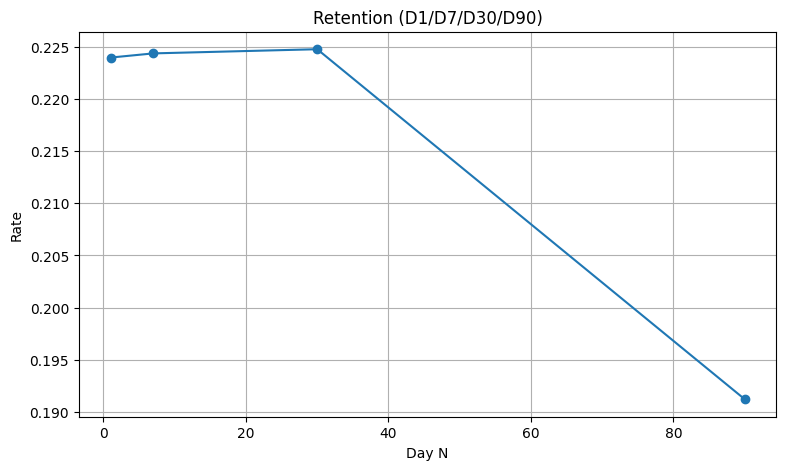

In [4]:

# Retention D1/D7/D30/D90
uu = u.dropna(subset=["user_id","created_at"]).copy()
uu["signup_day"] = uu["created_at"].dt.normalize()
act = active_any.merge(uu[["user_id","signup_day"]], on="user_id", how="inner")
act["delta"] = (act["day"] - act["signup_day"]).dt.days

rows = []
for d in [1,7,30,90]:
    denom = uu["user_id"].nunique()
    num = act.loc[act["delta"]==d, "user_id"].nunique()
    rows.append({"Day": d, "Retained Users": num, "Cohort Users": denom, "Retention Rate": (num/denom if denom else np.nan)})
ret_table = pd.DataFrame(rows)
display(ret_table)

plt.plot(ret_table["Day"], ret_table["Retention Rate"], marker="o")
plt.title("Retention (D1/D7/D30/D90)")
plt.xlabel("Day N")
plt.ylabel("Rate")
plt.show()


,Stage,Users
0,Signup,5000
1,Onboarded,0
2,Trial,0
3,Active Paid,2091


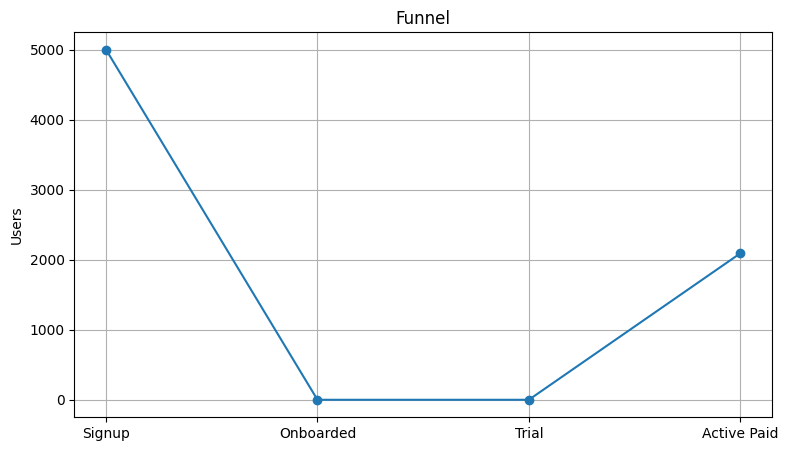

In [5]:

# Conversion: Free -> Active Paid
paid = s.loc[(~s["subscription_start_date"].isna()) & (~s["is_canceled"].fillna(False))].copy()
first_paid = paid.sort_values("subscription_start_date").groupby("user_id")["subscription_start_date"].first().rename("first_paid_start")
users_conv = uu.merge(first_paid, left_on="user_id", right_index=True, how="left")
users_conv["converted"] = users_conv["first_paid_start"].notna().astype(int)

# Trial via plan_type contains 'trial' (optional)
trial_users = set(s.loc[s.get("plan_type","").astype(str).str.contains("trial", case=False, na=False), "user_id"].unique()) if "plan_type" in s else set()

# Onboarded via onboarding_complete event
onb = set(ev.loc[ev.get("event_name","").astype(str).str.contains("onboarding_complete", case=False, na=False), "user_id"].unique()) if not ev.empty else set()

funnel = pd.DataFrame({
    "Stage":["Signup","Onboarded","Trial","Active Paid"],
    "Users":[uu["user_id"].nunique(), len(onb), len(trial_users), users_conv["converted"].sum()]
})
display(funnel)

plt.plot(funnel["Stage"], funnel["Users"], marker="o")
plt.title("Funnel")
plt.ylabel("Users")
plt.show()


In [6]:

# Export example chart
EXPORT_DIR = Path("exports"); EXPORT_DIR.mkdir(exist_ok=True)
plt.figure()
plt.plot(ret_table["Day"], ret_table["Retention Rate"], marker="o")
plt.title("Retention D1/D7/D30/D90")
p = EXPORT_DIR/"retention.png"
plt.savefig(p, dpi=200, bbox_inches="tight"); plt.close()
print("Saved figure:", p)


Saved figure: exports\retention.png
